In [ ]:
from dotenv import load_dotenv

import psycopg2

from telegram_data_models import Message
from telegram_quality_control.db import get_conn_string
from sqlalchemy import select

from pathlib import Path

import numpy as np
import pandas as pd
import os

from datetime import datetime

from tqdm import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib import ticker
import matplotlib as mpl

from telegram_quality_control.visualization import single_col_figure, double_col_figure

from cmcrameri import cm

figure_style = "print"

plt.style.use('./resources/mpl_styles/default.mplstyle')

load_dotenv()

output_folder = Path(os.environ["OUTPUT_FOLDER"])
scratch_folder = Path(os.environ["SCRATCH_FOLDER"])
output_folder.mkdir(exist_ok=True)
scratch_folder.mkdir(exist_ok=True)

message_table = Message.__table__

num_workers = 4

In [ ]:
cluster = LocalCluster(
    n_workers=num_workers,
    # threads_per_worker=1,
    # memory_limit="8GB",
    # death_timeout=100,
)
client = cluster.get_client()
client.dashboard_link

In [ ]:
db_url = get_conn_string(".env")

sql = select(message_table.c.id, message_table.c.date)

timestamps = pd.read_sql(sql.limit(100), db_url)
timestamps["date"].dt.date.value_counts()

In [ ]:
timestamps = dd.read_sql(
    select(message_table.c.id, message_table.c.date), db_url, index_col="id", npartitions=5000
)
timestamps

In [ ]:
counts = timestamps["date"].dt.date.value_counts()
counts = counts.compute()
counts.to_csv(output_folder / "messages_per_day.csv")

In [4]:
counts = pd.read_csv(output_folder / "messages_per_day.csv")
counts["date"] = pd.to_datetime(counts["date"])

counts = counts.sort_values("date")
counts = counts.reset_index(drop=True)

# regroup for weeks
counts = counts.groupby(pd.Grouper(key="date", freq="1W")).sum().reset_index()

counts

,date,count
0,2015-09-20,12
1,2015-09-27,43510
2,2015-10-04,131590
3,2015-10-11,191413
4,2015-10-18,230673
...,...,...
526,2025-10-19,2785213
527,2025-10-26,2109955
528,2025-11-02,1129737
529,2025-11-09,427097


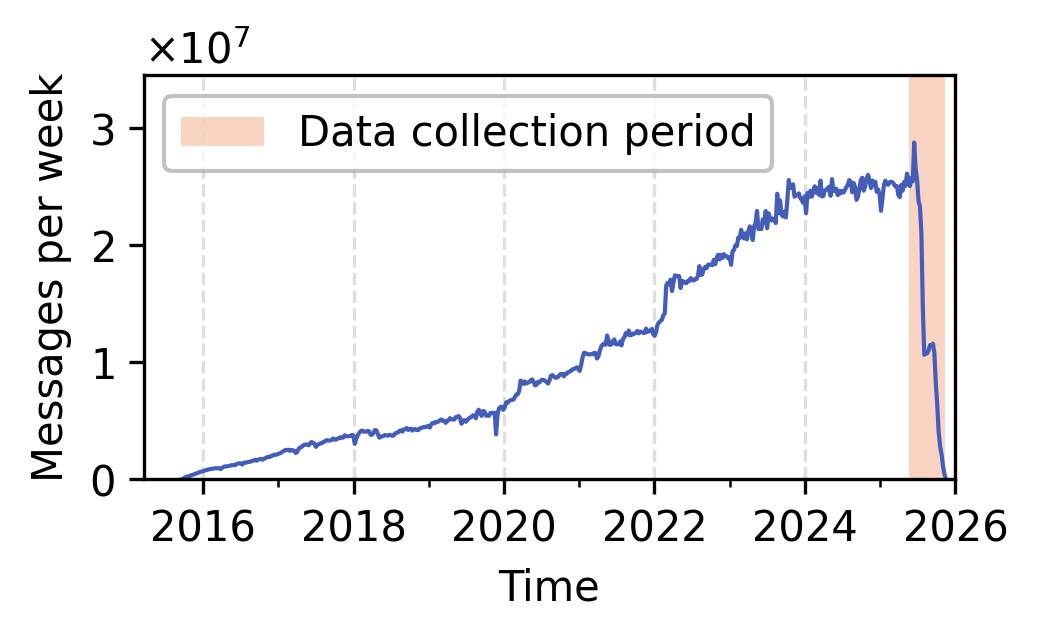

In [5]:
from telegram_quality_control.visualization import get_color_cycle

fig = single_col_figure(0.6)

crawl_begin = datetime(2025, 5, 20)
crawl_end = datetime(2025, 11, 11)

ax = fig.add_axes(111)

colors = get_color_cycle()

ax.axvspan(
    crawl_begin, crawl_end, color=colors[1], alpha=0.3, label="Data collection period", linewidth=0
)
ax.plot(counts["date"], counts["count"], color=colors[0], linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Messages per week")
ax.set_ylim(0, counts["count"].max() * 1.2)
ax.set_xlim(right=datetime(2026, 1, 1))
# set ticks at every two years
ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=2))
ax.xaxis.set_minor_locator(mpl.dates.YearLocator(base=1))

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

ax.legend()

ax.xaxis.grid(True, which='major', linestyle='--', alpha=0.5)

# fig.tight_layout()
fig.subplots_adjust(left=0.12, bottom=0.22, top=0.90, right=0.94)
fig.savefig("./figures/messages_per_week.png")
fig.savefig("./figures/messages_per_week.pdf")